In [1]:
import os
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [117]:
import datetime
import copy
import csv
sys.path.append('../')
from modules.Utils import TimeLog

In [118]:
DATA = "../data/books/correspond-frame-to-framelog/"

In [119]:
timelog = TimeLog()

### Main take-away

The frame logs need to have a row of zero inserted at beginning to correspond to the actual time experienced at that frame.
This is because a frame goes into buffer as soon as a frame is retreived. So you're actually "looking" at a frame from the previous loop. (See VideoCapture grab/retrieve for more on why this might be).
There's several experiments below designed to show this:

In [130]:
def framelogToCumFrametime(fn):
    ''' load framelog at fn, build the delay since first frame '''
    data = []
    with(open(DATA + fn, 'r')) as f:
        lines = csv.reader(f)
        for row in lines:
            data.append(float(row[0]))
            
    cumsum_data = [ sum(data[:i]) for i in range(len(data))]
    
    return cumsum_data

### Analyze Buffered Frame

Use a pre-planned sleep during frame-loop: 
a 0.3 sec sleep after the 4th frame after recordOn has but initialized.
This should mean 5th frame shows dramatic movement difference. But infact that difference doesn't show up until the 6th frame. This is because the 5th frame is actually taken immediately after 4th frame is retieved. So we use the framelogToCumFrametime() to set the right time for the frame:

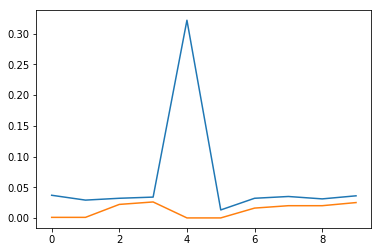

In [133]:
fn = "output81.txt"
data = timelog.load_log_data(DATA + fn)
plt.plot(data[:10])

frame num: 1 
t = 0


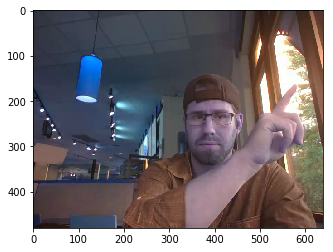

frame num: 2 
t = 0.0369


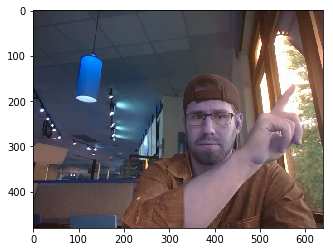

frame num: 3 
t = 0.0659


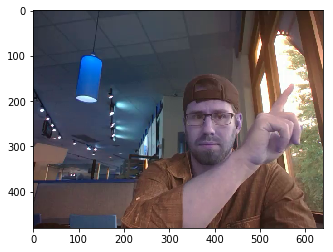

frame num: 4 
t = 0.0979


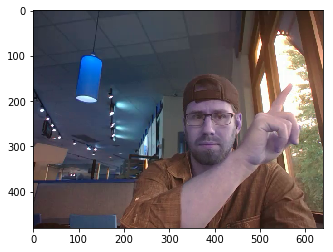

frame num: 5 
t = 0.1318


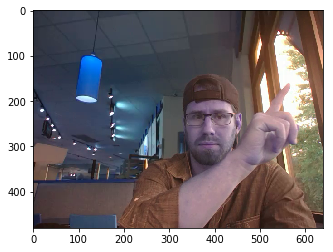

frame num: 6 
t = 0.4538


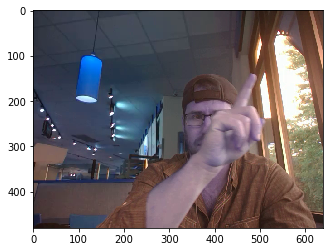

frame num: 7 
t = 0.4668


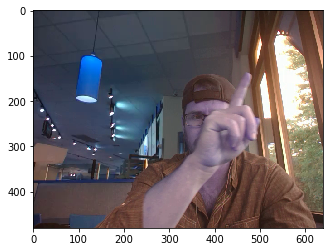

In [131]:
cam = cv2.VideoCapture(DATA + "output81.avi")

timelag = framelogToCumFrametime("output81.txt")

frame_ind = range(7)

for i in frame_ind:
    
    if i in frame_ind:
        print 'frame num: %s ' % str(i + 1)
        print 't = %s' % str(timelag[i])[:6]
    
    ret, frame = cam.read()
    
    if i in frame_ind:
        plt.imshow(frame.copy())
        plt.show()

### Analyze Buffer doesn't accumulate over multi-lags

Here we do a preplanned sleep after frame 4 and after frame 61. But we don't see "two buffered frames" accumulate, always it's one between. This is verified by the framatic change showing up in frame 63:

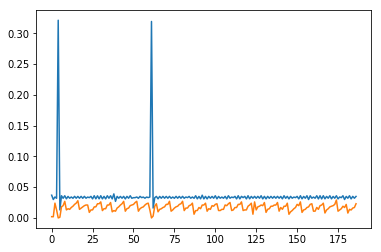

In [134]:
fn = "output82.txt"
data = timelog.load_log_data(DATA + fn)
plt.plot(data)

frame num: 1 
t = 0


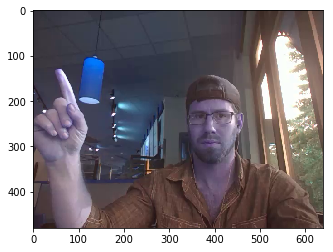

frame num: 2 
t = 0.0369


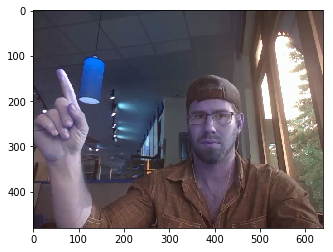

frame num: 3 
t = 0.0668


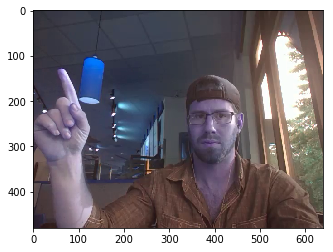

frame num: 4 
t = 0.1008


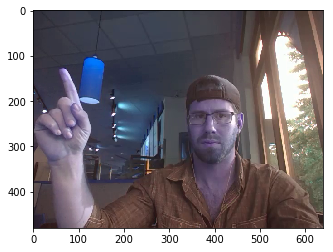

frame num: 5 
t = 0.1327


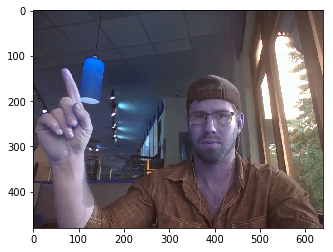

frame num: 6 
t = 0.4537


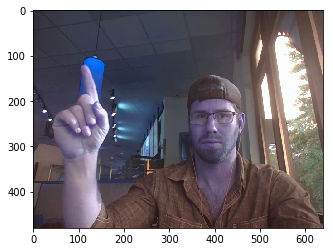

frame num: 7 
t = 0.4667


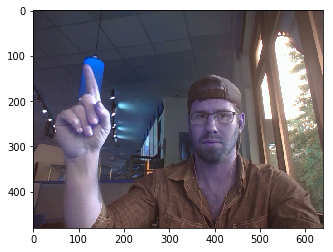

frame num: 60 
t = 2.2365


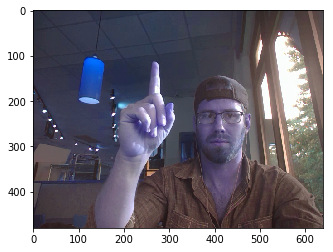

frame num: 61 
t = 2.2695


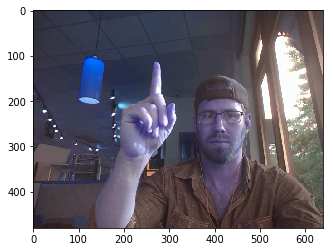

frame num: 62 
t = 2.3034


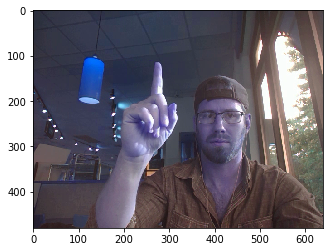

frame num: 63 
t = 2.6224


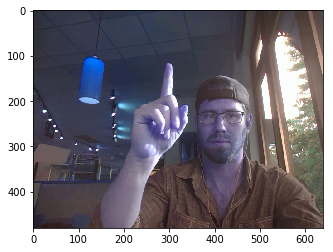

frame num: 64 
t = 2.6384


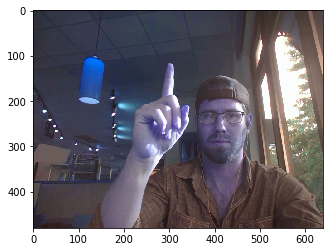

In [136]:
cam = cv2.VideoCapture(DATA + "output82.avi")

timelag = framelogToCumFrametime("output82.txt")

frame_ind = range(7)
frame_ind.extend(range(59,64))

for i in range(70):
    
    if i in frame_ind:
        print 'frame num: %s ' % str(i + 1)
        print 't = %s' % str(timelag[i])[:6]
    
    ret, frame = cam.read()
    
    if i in frame_ind:
        plt.imshow(frame.copy())
        plt.show()

### Analyze TimeDrift

Use a video of a stopwatch to compare internal framelog times to time on the watch. Note: frames read faster than watch updates screen, so some adjacent frames are duplicate time, and each frame is a point estimate but 
+/- 35ms (0.07 second increments on the screen)

Drift is at worst +/- 200ms but more often +/- 100ms

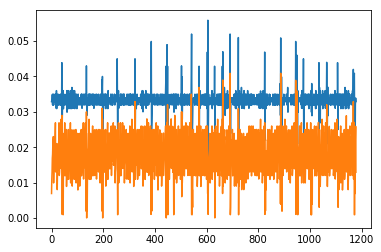

In [128]:
#Here's a 30 second of a stopwatch:
#see the jumps from normal 30fps, 
#to 2x of average normal frame read time
fn = "output77.txt"
data = timelog.load_log_data(DATA + fn)
plt.plot(data)

In [122]:
#find the frame indexes where largest discrpancies occured
t = [x[0] for x in data]
print t[:10]
t_tmp = copy.copy(t)
t_tmp.sort(reverse=True)
print t_tmp[:5]                    #largest discrepancies
max_ind = [t.index(t_tmp[i]) for i in range(5)]
print max_ind

[0.0329, 0.0329, 0.033, 0.0349, 0.032, 0.035, 0.0319, 0.034, 0.0319, 0.035]
[0.0559, 0.052, 0.052, 0.051, 0.0509]
[605, 542, 542, 723, 887]


In [123]:
#load the log
fn = "output77.txt"
cumsum_data = framelogToCumFrametime(fn)

print cumsum_data[:4]
print cumsum_data[1100:1103]

[0, 0.0329, 0.0658, 0.0988]
[36.69709999999992, 36.72909999999992, 36.76299999999992]


frame num: 1 
t = 0
clock reads: 1:53:730000


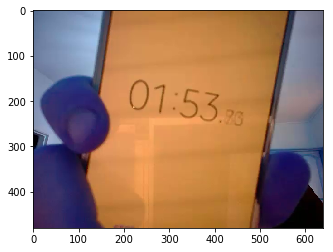

frame num: 2 
t = 0.0329
clock reads: 1:53:762900


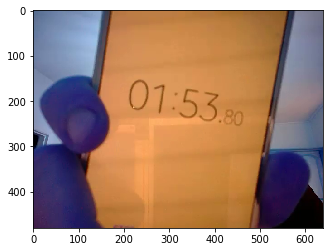

frame num: 100 
t = 3.3012
clock reads: 1:57:31200


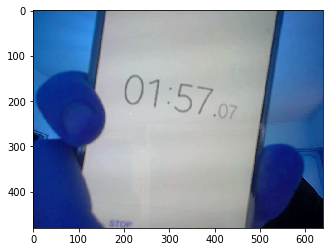

frame num: 300 
t = 9.9735
clock reads: 2:3:703500


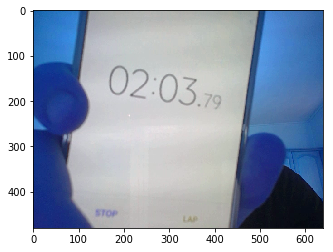

frame num: 500 
t = 16.646
clock reads: 2:10:376300


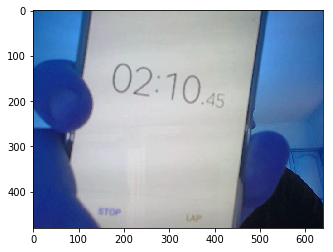

frame num: 900 
t = 29.989
clock reads: 2:23:719900


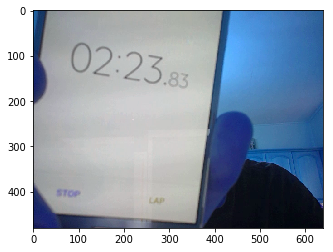

frame num: 1100 
t = 36.662
clock reads: 2:30:392200


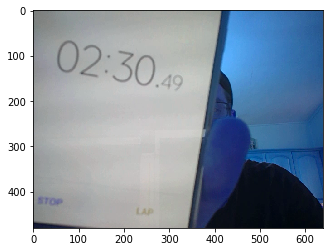

last frame i: 1179


In [127]:
#Use this 30 second video of a stopwatch to analyze
#time-drift. To do this compare 'clock reads' printout, to time
#on the clock:
#Below we see +0.25sec (at frame 100) to -0.12 secs at (frame900)
#Could this be due to 1000x float arithmetic?

fn = "output77.avi"

cam = cv2.VideoCapture(DATA + fn)

frame_ind.extend([1, 2, 100, 300,500, 900, 1100])
# frame_ind.extend(range(max_ind[0]-2, max_ind[0] +4))

t0 = datetime.datetime(2000,1,1,0,1,53, 730000)
tmp_img = []

i = 0
while(True):
    
    if (i+1) in frame_ind:
        
        print 'frame num: %s ' % str(i + 1)
        print 't = %s' % str(cumsum_data[i])[:6]
        
        td = datetime.timedelta(seconds=cumsum_data[i])
        tnow = t0 + td
        print 'clock reads: %i:%i:%i' % (tnow.minute, tnow.second, tnow.microsecond)
    
    i += 1
    ret, frame = cam.read()
    
    if not(ret):
        print 'last frame i: %i' % (i - 1)
        break
        
    if i in frame_ind and ret:
        tmp_img.append(frame.copy())
        plt.imshow(frame.copy())
        plt.show()